<a href="https://colab.research.google.com/github/ucheokechukwu/Stock-Prediction-with-Supervised-and-Reinforcement-Learning/blob/main/src/notebooks/Classifier_Model_building.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


import warnings
warnings.filterwarnings('ignore')

# Preparing the Dataset


In [21]:
data = pd.read_csv('/content/drive/MyDrive/stock_model/dataframe_for_model.csv',
            parse_dates=['Date'],
            index_col=['Date']).dropna()

data.head()

,Volume,Move,Forecast,0,1,2,0_SPX,1_SPX,2_SPX
Date,,,,,,,,,
2015-01-07,1.005468,0,1.0,-0.033832,-0.022282,-0.017089,-0.009385,-0.020523,-0.006259
2015-01-08,1.005349,1,2.0,-0.022282,-0.017089,0.037738,-0.020523,-0.006259,0.026292
2015-01-09,1.005322,2,1.0,-0.017089,0.037738,0.016188,-0.006259,0.026292,-0.000310
2015-01-12,1.006957,1,1.0,0.037738,0.016188,-0.047262,0.026292,-0.000310,-0.005515
2015-01-13,1.008898,1,1.0,0.016188,-0.047262,0.014290,-0.000310,-0.005515,0.003234


# Baseline Model: Naive Forecast
We will simply shift the model by one day, and evaluate the performance of the model.

X[t+1] = X[t]

To do this, we have to use the original values of 'Close', not the price movements. Perform the shift. Then convert 'Close' -> 'Close'.diff() -> 'Movement'

,Close
Date,
2023-06-16,431.96
2023-06-15,445.27
2023-06-14,440.86


,Close,Close_diff
Date,,
2023-06-16,431.96,NaN
2023-06-15,445.27,0.029892
2023-06-14,440.86,-0.010003


1    1356
0     390
2     383
Name: Close_diff, dtype: int64

,Close,Close_diff,Move
Date,,,
2023-06-15,445.27,0.029892,2
2023-06-14,440.86,-0.010003,1
2023-06-13,435.73,-0.011773,1


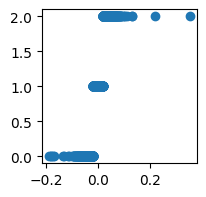

In [177]:
# download the data

Close = pd.read_csv('/content/drive/MyDrive/stock_model/NFLX_fuller.csv',
                        parse_dates=['Date']).set_index('Date')
Close = Close['2015':]['Close'].to_frame()
display(Close.head(3))

# converting it to diff
Close['Close_diff'] = Close['Close'].diff()/Close['Close']
display(Close.head(3))

# converting it to discrete bins
# qbins = pd.qcut(Close['Close_diff'], q=3, labels = list(range(3)), retbins=True)
# Close['Move'] = qbins[0]

from helper_functions import hypertune_bins
Close['Move'] = hypertune_bins(Close['Close_diff'], [-0.020,  0.017])

Close = Close.dropna()
Close.head(3)

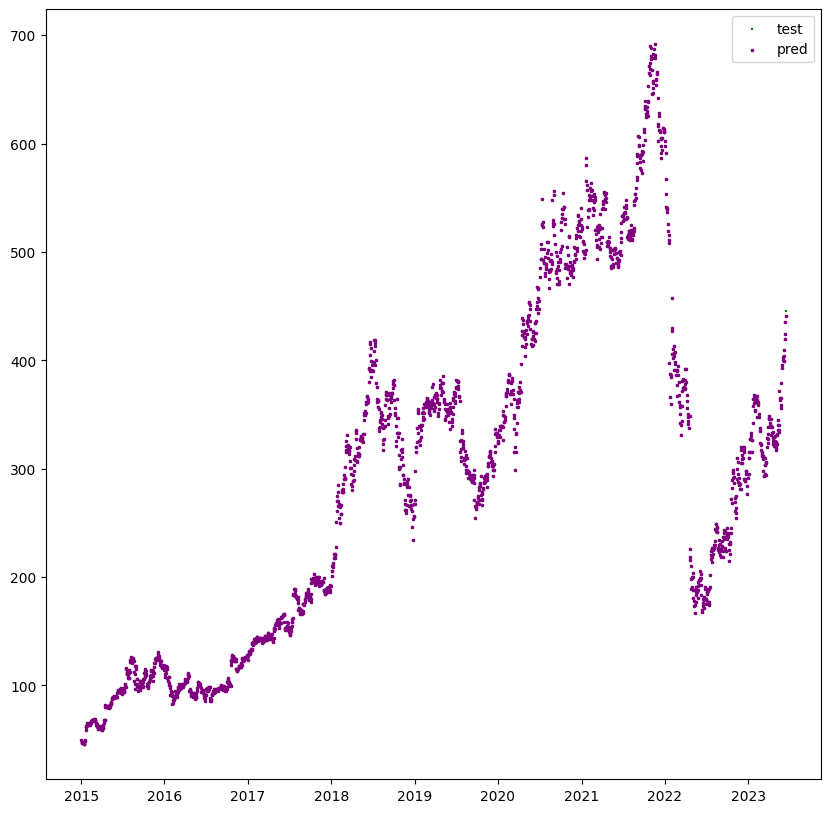

In [178]:
# shifting the data
ytrue = Close['Close'][:-1]
ypred = Close['Close'][1:]

# visualizing this
plt.figure(figsize=(10,10))
plt.scatter(ytrue.index, ytrue, color='green', label='test', s=3, marker="+")
plt.scatter(ypred.index, ypred, color='purple', label='pred', s=3, marker="x")
plt.legend()

In [179]:
from sklearn.metrics import accuracy_score
y_true = Close['Move'][:-1]
y_pred = Close['Move'][1:]
accuracy_score(y_true, y_pred)

0.5030559473436765

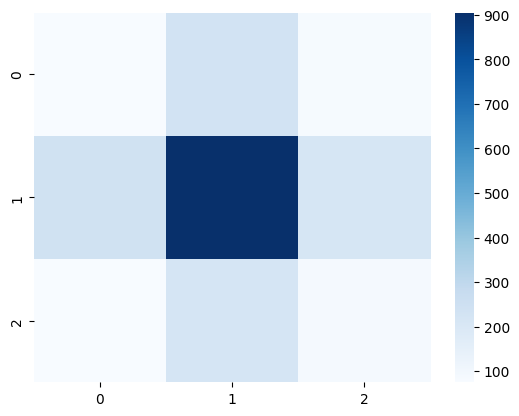

              precision    recall  f1-score   support

           0       0.20      0.20      0.20       390
           1       0.67      0.67      0.67      1355
           2       0.23      0.23      0.23       382

    accuracy                           0.50      2127
   macro avg       0.37      0.37      0.37      2127
weighted avg       0.50      0.50      0.50      2127



In [180]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_true, y_pred)
sns.heatmap(cf_matrix, cmap='Blues')
plt.show()
print(classification_report(y_true, y_pred))

## Evaluations
This function will be called to append to the Evaluation dictionary.

In [183]:
# Setting up evaluation matrix


def eval (y_true, y_pred):
    y_pred = np.squeeze(y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
    accuracy = accuracy_score(y_true, y_pred)
    clf_report = classification_report(y_true, y_pred)
    cf_matrix = confusion_matrix(y_true, y_pred)

    return {'accuracy':accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1}, \
            {'classification_report': clf_report,
            'confusion_matrix': cf_matrix}

In [184]:
metrics_log = {}
metrics_log['baseline'], _ = eval(y_true, y_pred)
metrics_log

{'baseline': {'accuracy': 0.5030559473436765,
  'precision': 0.5030559473436765,
  'recall': 0.5030559473436765,
  'f1': 0.5030559473436765}}

# Model Experiments 🔬:


To run a series of experiments. Starting with a simple model, then a CNN model then an LSTM model and pick the one with the best performance. After that, another series of experiments will be run to test out the features.

Model Experiments:
1. Simple 3 -layer NN
2. CNN
3. LSTM RNN
4. 3-layer LSTM model with drop out.
5. Combined CNN and LSTM layer


Hyperparameter Tuning.
1. Batch size
2. Scaling layer - Batch Normalization
3. Optimizers - SGD, Adamax.

### Frequent Functions

,Volume,Move,Forecast,0,1,2,0_SPX,1_SPX,2_SPX
Date,,,,,,,,,
2015-01-07,1.005468,0,1.0,-0.033832,-0.022282,-0.017089,-0.009385,-0.020523,-0.006259
2015-01-08,1.005349,1,2.0,-0.022282,-0.017089,0.037738,-0.020523,-0.006259,0.026292
2015-01-09,1.005322,2,1.0,-0.017089,0.037738,0.016188,-0.006259,0.026292,-0.000310
2015-01-12,1.006957,1,1.0,0.037738,0.016188,-0.047262,0.026292,-0.000310,-0.005515
2015-01-13,1.008898,1,1.0,0.016188,-0.047262,0.014290,-0.000310,-0.005515,0.003234
...,...,...,...,...,...,...,...,...,...
2023-06-08,1.002675,0,1.0,-0.011734,-0.022812,-0.002002,0.006166,-0.010001,0.005040
2023-06-09,1.006717,1,0.0,-0.022812,-0.002002,0.016611,-0.010001,0.005040,-0.008173
2023-06-12,1.002652,0,1.0,-0.002002,0.016611,-0.018333,0.005040,-0.008173,0.002388


In [32]:
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
early_stop = EarlyStopping(monitor='accuracy', patience=10)
from tensorflow import one_hot
import tensorflow as tf

In [142]:
def model_evaluation(model, modelname, filepath, X_test, y_test, metrics_log=metrics_log):
    """loads the saved best performing model
    and calls the eval function to evaluate it
    """
    model.load_weights(filepath)
    display("shape of x-te:", X_test.shape)
    y_pred = np.squeeze(model.predict(X_test)).argmax(axis=1)
    display("shape of y_pred:", y_pred.shape)
    scores = eval(y_test, y_pred)
    metrics_log[modelname] = scores[0]
    display(metrics_log)


def save_best(model):
    """
    saves the best epoch performing weights into a filepath
    that is based on the name of the model
    """
    return tf.keras.callbacks.ModelCheckpoint(
        filepath='output/'+model,
        save_weights_only=True,
        monitor='val_accuracy',
        mode='auto',
        save_best_only=True)

# function to train test split the X and y
def train_test_splits(data, test_split=0.2):
    """
    Input: X and y
    Output: X_train, X_test, y_train, y_test in that order
    """

    data = pd.concat([data[:'2021-10'], data['2022-06':]])
    from sklearn.preprocessing import StandardScaler
    scal = StandardScaler()
    tmp = data.copy()
    X = tmp.drop(columns=['Forecast'])
    y = tmp['Forecast'].values
    X = scal.fit_transform(X)


    split = round(len(X) * (1-test_split))
    # returns in order: X_train, X_test, y_train, y_test
    X_train, X_test, y_train, y_test = X[:split], X[split:], y[:split], y[split:]

    display (X_train.shape, X_test.shape, y_train.shape, y_test.shape)
    return X_train, X_test, y_train, y_test,


def train_model(model, data, model_name, epochs=1000):
    # definining checkpoint
    early_stop = EarlyStopping(monitor='loss', patience=10)
    # train test split
    X_train, X_test, y_train, y_test = train_test_splits(data)

    history = model.fit(X_train,
           y_train,
           epochs=epochs,
           verbose=1,
           batch_size=128,
           validation_data=(X_test, y_test),
           callbacks=[early_stop, save_best(model_name)]
           ) # create ModelCheckpoint callback to save best model

    return history, 'output/'+model_name, X_test, y_test

## 1. Experiment 1: Simple 3 - layer NN
A single dense layer with
- 128 hidden units and ReLU activation

An output layer with
- softmax activation
- Adam optimizer and MAE loss function
- Batch size of 128
- 100 epochs

In [60]:
# set up the train and test dataset
X_train, X_test, y_train, y_test = train_test_splits(data, test_split=0.2)

(1699, 8)

(425, 8)

(1699,)

(425,)

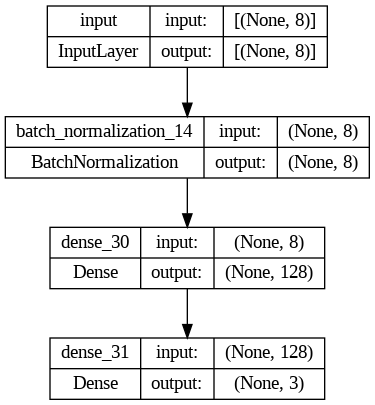

In [101]:
# build and compile the model
model_name = "model1"
tf.random.set_seed(88)
features = len(data.columns) - 1
input = layers.Input(shape=(features,), name='input')
scaling = layers.BatchNormalization(synchronized=True)(input)
hidden = layers.Dense(128, activation='relu')(scaling)
output = layers.Dense(3, activation="softmax")(hidden)

model1 = tf.keras.Model(inputs=input,
                         outputs=output,
                         name=model_name)
# compile
model1.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
# visualize
plot_model(model1, show_shapes=True)

In [103]:
history, filepath, X_test, y_test = train_model(model1, data, model_name, epochs=500)
model_evaluation(model1, model_name, filepath, X_test, y_test)

(1582, 8)

(396, 8)

(1582,)

(396,)

Epoch 1/500
13/13 [==============================] - 0s 13ms/step - loss: 0.9256 - accuracy: 0.6530 - val_loss: 0.8928 - val_accuracy: 0.6439
Epoch 2/500
13/13 [==============================] - 0s 7ms/step - loss: 0.9106 - accuracy: 0.6530 - val_loss: 0.8813 - val_accuracy: 0.6439
Epoch 3/500
13/13 [==============================] - 0s 5ms/step - loss: 0.9030 - accuracy: 0.6530 - val_loss: 0.8727 - val_accuracy: 0.6439
Epoch 4/500
13/13 [==============================] - 0s 7ms/step - loss: 0.8936 - accuracy: 0.6549 - val_loss: 0.8709 - val_accuracy: 0.6439
Epoch 5/500
13/13 [==============================] - 0s 7ms/step - loss: 0.8885 - accuracy: 0.6536 - val_loss: 0.8677 - val_accuracy: 0.6439
Epoch 6/500
13/13 [==============================] - 0s 10ms/step - loss: 0.8844 - accuracy: 0.6555 - val_loss: 0.8667 - val_accuracy: 0.6439
Epoch 7/500
13/13 [==============================] - 0s 9ms/step - loss: 0.8792 - accuracy: 0.6574 - val_loss: 0.8672 - val_accuracy: 0.6465
Epoch 8/500

'shape of x-te:'

(396, 8)

13/13 [==============================] - 0s 1ms/step


'shape of y_pred:'

(396,)

{'baseline': {'accuracy': 0.3385049365303244,
  'precision': 0.3385049365303244,
  'recall': 0.3385049365303244,
  'f1': 0.3385049365303244},
 'model1': {'accuracy': 0.6565656565656566,
  'precision': 0.6256313131313131,
  'recall': 0.6565656565656566,
  'f1': 0.5415648027945075}}

In [71]:
model1.predict(X_test)

14/14 [==============================] - 0s 4ms/step


array([[0.09974518, 0.80902755, 0.09122724],
       [0.17958409, 0.69013983, 0.13027605],
       [0.1667118 , 0.69249684, 0.14079137],
       ...,
       [0.18752488, 0.6299953 , 0.18247978],
       [0.23983702, 0.5112394 , 0.24892357],
       [0.23999482, 0.5025516 , 0.2574535 ]], dtype=float32)

## Model 2: CNN

In [ ]:
# set random seed for reproducible results
tf.random.set_seed(88)
# construct model
model_name = 'model2'
features = len(data.columns) - 1
input = layers.Input(shape=(features,), name='input')
reshape = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(input)
cnn = layers.Conv1D(filters=128, kernel_size=32, padding='same', activation="relu")(reshape)
# pool = layers.MaxPool1D(3)(cnn)
dense = layers.Dense(32, activation='relu')(cnn)
output = layers.Dense(3, activation='softmax')(dense)


model2 = tf.keras.Model(inputs=input,
                         outputs=output,
                         name=model_name)
model2.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
# visualize
plot_model(model2, show_shapes=True)

In [114]:
history2, filepath, X_test, y_test = train_model(model2, data, model_name, epochs=500)
model_evaluation(model2, model_name, filepath, X_test, y_test)

(1582, 8)

(396, 8)

(1582,)

(396,)

Epoch 1/500
13/13 [==============================] - 1s 22ms/step - loss: 1.0527 - accuracy: 0.5979 - val_loss: 0.9885 - val_accuracy: 0.6433
Epoch 2/500
13/13 [==============================] - 0s 4ms/step - loss: 0.9748 - accuracy: 0.6505 - val_loss: 0.9160 - val_accuracy: 0.6433
Epoch 3/500
13/13 [==============================] - 0s 4ms/step - loss: 0.9223 - accuracy: 0.6526 - val_loss: 0.8830 - val_accuracy: 0.6433
Epoch 4/500
13/13 [==============================] - 0s 4ms/step - loss: 0.8973 - accuracy: 0.6559 - val_loss: 0.8700 - val_accuracy: 0.6433
Epoch 5/500
13/13 [==============================] - 0s 4ms/step - loss: 0.8827 - accuracy: 0.6540 - val_loss: 0.8597 - val_accuracy: 0.6433
Epoch 6/500
13/13 [==============================] - 0s 4ms/step - loss: 0.8715 - accuracy: 0.6489 - val_loss: 0.8608 - val_accuracy: 0.6433
Epoch 7/500
13/13 [==============================] - 0s 5ms/step - loss: 0.8639 - accuracy: 0.6521 - val_loss: 0.8630 - val_accuracy: 0.6433
Epoch 8/500


'shape of x-te:'

(396, 8)

13/13 [==============================] - 0s 1ms/step


'shape of y_pred:'

(396,)

{'baseline': {'accuracy': 0.3385049365303244,
  'precision': 0.3385049365303244,
  'recall': 0.3385049365303244,
  'f1': 0.3385049365303244},
 'model1': {'accuracy': 0.6565656565656566,
  'precision': 0.6256313131313131,
  'recall': 0.6565656565656566,
  'f1': 0.5415648027945075},
 'model2': {'accuracy': 0.6439393939393939,
  'precision': 0.41465794306703396,
  'recall': 0.6439393939393939,
  'f1': 0.5044686496299399},
 'model3_lstm': {'accuracy': 0.6540404040404041,
  'precision': 0.6427709739885905,
  'recall': 0.6540404040404041,
  'f1': 0.5366743725070147}}

## Model 3 - Single Layer LSTM

In [ ]:
# set random seed for reproducible results
tf.random.set_seed(88)
model_name = 'model3_lstm'
# building the dropout model
features = len(data.columns) - 1
input = layers.Input(shape=(features,), name='input')
scaling = layers.LayerNormalization()(input)

reshape = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(scaling)
lstm = layers.LSTM(256, dropout=0.1)(reshape)

output = layers.Dense(3, activation='softmax')(lstm)

model3 = tf.keras.Model(inputs=input,
                        outputs=output,
                        name=model_name)


model3.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
# visualize
plot_model(model3, show_shapes=True)

In [111]:
history3, filepath, X_test, y_test = train_model(model3, data, model_name, epochs=500)
model_evaluation(model3, model_name, filepath, X_test, y_test)

(1582, 8)

(396, 8)

(1582,)

(396,)

Epoch 1/500
13/13 [==============================] - 2s 46ms/step - loss: 1.0810 - accuracy: 0.4659 - val_loss: 1.0337 - val_accuracy: 0.5985
Epoch 2/500
13/13 [==============================] - 0s 12ms/step - loss: 1.0344 - accuracy: 0.5752 - val_loss: 0.9744 - val_accuracy: 0.6389
Epoch 3/500
13/13 [==============================] - 0s 11ms/step - loss: 0.9860 - accuracy: 0.6169 - val_loss: 0.9208 - val_accuracy: 0.6389
Epoch 4/500
13/13 [==============================] - 0s 13ms/step - loss: 0.9397 - accuracy: 0.6365 - val_loss: 0.8850 - val_accuracy: 0.6439
Epoch 5/500
13/13 [==============================] - 0s 12ms/step - loss: 0.9007 - accuracy: 0.6536 - val_loss: 0.8728 - val_accuracy: 0.6439
Epoch 6/500
13/13 [==============================] - 0s 10ms/step - loss: 0.8836 - accuracy: 0.6530 - val_loss: 0.8753 - val_accuracy: 0.6439
Epoch 7/500
13/13 [==============================] - 0s 12ms/step - loss: 0.8771 - accuracy: 0.6530 - val_loss: 0.8783 - val_accuracy: 0.6439
Epoch 

'shape of x-te:'

(396, 8)

13/13 [==============================] - 0s 2ms/step


'shape of y_pred:'

(396,)

{'baseline': {'accuracy': 0.3385049365303244,
  'precision': 0.3385049365303244,
  'recall': 0.3385049365303244,
  'f1': 0.3385049365303244},
 'model1': {'accuracy': 0.6565656565656566,
  'precision': 0.6256313131313131,
  'recall': 0.6565656565656566,
  'f1': 0.5415648027945075},
 'model2': {'accuracy': 0.6439393939393939,
  'precision': 0.41465794306703396,
  'recall': 0.6439393939393939,
  'f1': 0.5044686496299399},
 'model3_lstm': {'accuracy': 0.6439393939393939,
  'precision': 0.41465794306703396,
  'recall': 0.6439393939393939,
  'f1': 0.5044686496299399}}

## Model 4 - 3 layer LSTM

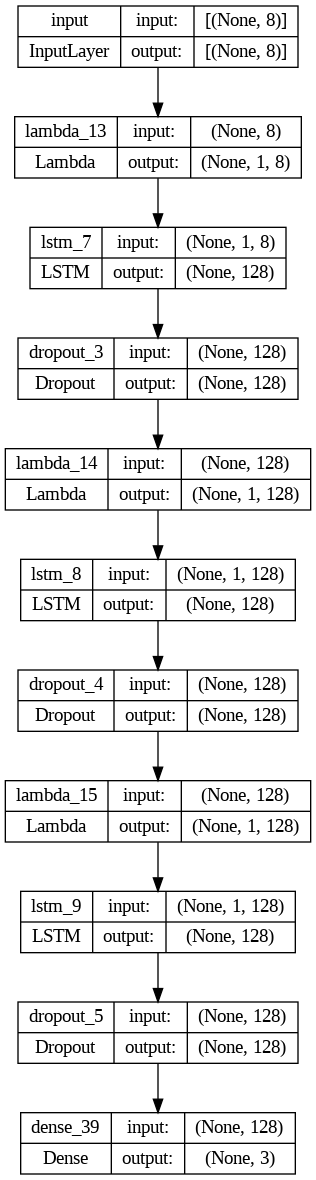

In [115]:
# set random seed for reproducible results
tf.random.set_seed(88)
model_name = 'model4_lstm3'
# building the dropout model
features = len(data.columns) - 1
input = layers.Input(shape=(features,), name='input')

reshape = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(input)
lstm = layers.LSTM(128)(reshape)
drop1 = layers.Dropout(0.2)(lstm)
reshape2 = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(drop1)
lstm2 = layers.LSTM(128)(reshape2)
drop2 = layers.Dropout(0.2)(lstm2)
reshape3 = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(drop2)
lstm3 = layers.LSTM(128)(reshape3)
drop3 = layers.Dropout(0.2)(lstm3)

output = layers.Dense(3, activation='softmax')(drop3)

model4 = tf.keras.Model(inputs=input,
                        outputs=output,
                        name=model_name)

model4.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
# visualize
plot_model(model4, show_shapes=True)

In [116]:
history4, filepath, X_test, y_test = train_model(model4, data, model_name, epochs=500)
model_evaluation(model4, model_name, filepath, X_test, y_test)

(1582, 8)

(396, 8)

(1582,)

(396,)

Epoch 1/500
13/13 [==============================] - 5s 89ms/step - loss: 1.0854 - accuracy: 0.6233 - val_loss: 1.0634 - val_accuracy: 0.6439
Epoch 2/500
13/13 [==============================] - 0s 15ms/step - loss: 1.0395 - accuracy: 0.6530 - val_loss: 0.9903 - val_accuracy: 0.6439
Epoch 3/500
13/13 [==============================] - 0s 16ms/step - loss: 0.9507 - accuracy: 0.6536 - val_loss: 0.8813 - val_accuracy: 0.6439
Epoch 4/500
13/13 [==============================] - 0s 15ms/step - loss: 0.8908 - accuracy: 0.6542 - val_loss: 0.8907 - val_accuracy: 0.6439
Epoch 5/500
13/13 [==============================] - 0s 22ms/step - loss: 0.8809 - accuracy: 0.6549 - val_loss: 0.8711 - val_accuracy: 0.6439
Epoch 6/500
13/13 [==============================] - 0s 24ms/step - loss: 0.8756 - accuracy: 0.6555 - val_loss: 0.8703 - val_accuracy: 0.6439
Epoch 7/500
13/13 [==============================] - 0s 25ms/step - loss: 0.8728 - accuracy: 0.6561 - val_loss: 0.8703 - val_accuracy: 0.6439
Epoch 

'shape of x-te:'

(396, 8)

13/13 [==============================] - 1s 4ms/step


'shape of y_pred:'

(396,)

{'baseline': {'accuracy': 0.3385049365303244,
  'precision': 0.3385049365303244,
  'recall': 0.3385049365303244,
  'f1': 0.3385049365303244},
 'model1': {'accuracy': 0.6565656565656566,
  'precision': 0.6256313131313131,
  'recall': 0.6565656565656566,
  'f1': 0.5415648027945075},
 'model2': {'accuracy': 0.6439393939393939,
  'precision': 0.41465794306703396,
  'recall': 0.6439393939393939,
  'f1': 0.5044686496299399},
 'model3_lstm': {'accuracy': 0.6540404040404041,
  'precision': 0.6427709739885905,
  'recall': 0.6540404040404041,
  'f1': 0.5366743725070147},
 'model4_lstm3': {'accuracy': 0.6565656565656566,
  'precision': 0.6213465369224531,
  'recall': 0.6565656565656566,
  'f1': 0.5461079366859521}}

# Hyperparameter Tuning

I will hyperparameter tune the CNN/LSTM layer.

1. Training Batch size - 16, 32, 128
2. Number of LSTM nodes - 32, 128
3. CNN layer - True or False
4. LSTM activation - relu, tanh
4. optimizer - adam, sgd, adamax

In [157]:
# these 2 functions need to be modified
# to enable hyperparameter tuning

def model_building_compiling_tuning(data,
                             lstm_nodes=128,
                                    cnn = False,
                             opt='adam',
                             activ='relu'):

    """inputs: the training dataset
    outputs: an LSTM model
    """
    tf.random.set_seed(88)
    features = len(data.columns) - 1 # extracting the number of features to check the shape

    # building the CNN model
    input = layers.Input(shape=(features,), name='input')
    reshape = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(input)
    if cnn == True:

        cnn_layer = layers.Conv1D(filters=128, kernel_size=32, padding='same', activation="relu")(reshape)
        x = cnn_layer
    else:
        x = reshape

    # reshape = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(x)
    lstm = layers.LSTM(lstm_nodes, activation=activ)(x)
    output = layers.Dense(3, activation='softmax')(lstm)

    model = tf.keras.Model(inputs=input,
                            outputs=output,
                            name="model")

    # visualizing the model
    plot_model(model, show_shapes=True)
    # compiling the model
    model.compile(loss="sparse_categorical_crossentropy",
                optimizer=opt,
                metrics=["accuracy"])
    return model

def model_training_tuning(model, data, model_name, epochs=5,
                   batch_size=32):
    """
    splits the dataset into training/test and fits the model
    inputs: the compiled model, and the X, y dataset and the model_name for the checkpoint
    outputs: the split dataset X_test, y_test
    log (history) of the model fitting process,
    the filepath for the checkpoints
    """
    # split the data
    X_train, X_test, y_train, y_test = train_test_splits(data, test_split=0.25)

    #checkpoints
    early_stop = EarlyStopping(monitor='loss', patience=10)

    # Fit model
    history = model.fit(X_train,
           y_train,
           epochs=epochs,
           verbose=0,
           batch_size=32,
           validation_data=(X_test, y_test),
           callbacks=[save_best(model_name)]
           ) # create ModelCheckpoint callback to save best model

    return history, 'output/'+model_name, X_test, y_test

In [ ]:
def build_model_tuning():

    from sklearn.model_selection import ParameterGrid

    params = {
            'batch_size' : [16, 32, 128],
            'lstm_nodes' : [32, 128],
            'cnn' : [True, False],
            'opt' : ['adam', 'adamax', 'sgd'],
            'activ' : ['relu', 'tanh']
        }
    param_grid = ParameterGrid(params)
    # start the GridSearch

    for dict_ in tqdm(param_grid):
        print('Parameters :', dict_.values())
        activ, batch_size, cnn, lstm_nodes, opt = dict_.values()
        model_name = f"hypertuning_{batch_size}_{lstm_nodes}_{cnn}_{opt}_{activ}"

        # build and compile the model

        model = model_building_compiling_tuning(data, lstm_nodes,
                             cnn,
                             opt,
                             activ)
        # display(plot_model(model, show_shapes=True))

        # train the model
        model_name = model_name
        _, filepath, X_test, y_test = model_training_tuning(model, data,
                                                            model_name, epochs=500, batch_size = batch_size)

        # evaluate the model
        model_evaluation(model, model_name, filepath, X_test, y_test)



from tqdm import tqdm
build_model_tuning()

### Results

In [164]:
results = pd.DataFrame(metrics_log).T

In [191]:
results

,baseline,model1,model2,model3_lstm,model4_lstm3,hypertuning_16_32_True_adam_relu,hypertuning_16_32_True_adamax_relu,hypertuning_16_32_True_sgd_relu,hypertuning_16_128_True_adam_relu,hypertuning_16_128_True_adamax_relu,...,hypertuning_128_32_True_sgd_tanh,hypertuning_128_128_True_adam_tanh,hypertuning_128_128_True_adamax_tanh,hypertuning_128_128_True_sgd_tanh,hypertuning_128_32_False_adam_tanh,hypertuning_128_32_False_adamax_tanh,hypertuning_128_32_False_sgd_tanh,hypertuning_128_128_False_adam_tanh,hypertuning_128_128_False_adamax_tanh,hypertuning_128_128_False_sgd_tanh
accuracy,0.503056,0.656566,0.643939,0.654040,0.656566,0.655870,0.657895,0.659919,0.657895,0.657895,...,0.657895,0.657895,0.657895,0.659919,0.653846,0.657895,0.655870,0.655870,0.657895,0.657895
precision,0.503056,0.625631,0.414658,0.642771,0.621347,0.609027,0.693761,0.669159,0.609894,0.653559,...,0.653559,0.609894,0.666969,0.593535,0.651805,0.592179,0.666095,0.616259,0.645685,0.666969
recall,0.503056,0.656566,0.643939,0.654040,0.656566,0.655870,0.657895,0.659919,0.657895,0.657895,...,0.657895,0.657895,0.657895,0.659919,0.653846,0.657895,0.655870,0.655870,0.657895,0.657895
f1,0.503056,0.541565,0.504469,0.536674,0.546108,0.525514,0.530735,0.539667,0.529902,0.534702,...,0.534702,0.529902,0.531325,0.545939,0.525838,0.544315,0.526853,0.533567,0.537999,0.531325


In [192]:
results.to_csv('/content/drive/MyDrive/stock_model/hyperparametertuning_results.csv')

In [193]:
results.idxmax(axis=1)

accuracy       hypertuning_16_32_True_sgd_relu
precision    hypertuning_16_128_True_adam_tanh
recall         hypertuning_16_32_True_sgd_relu
f1                                model4_lstm3
dtype: object

* the model with the best results had the following configuration:
- 16 LSTM nodes
- Batch 32
- One CNN layer
- 'SGD' optimizer
- 'Relu' activation in the LSTM layer.

# Deployment

The model will be deployed on a cloud-hosted environment and we will be able to access its predictions. The process to this involves:

1. Saving and loading the model
2. Saving the most recent record of the database which will be used as input to the model for the next day's prediction.
3. The Flask-based app that will be used to broadcast the model's results.
4. The schedule()-based app that will retrieve the latest information of NFLX from the Financial API.


In [ ]:
# saving the model
model.save('model/model')

In [ ]:
# keeping the most recent record of the database
_, X_test, _, _ = train_test_splits(X, y, test_split=0.2)
display (X_test)

# import pickle for saving data
import pickle
lastrecord =  = X_test.iloc[-1].values.reshape(1,-1) # saved this way to prevent shape errors.
pickle.dump(last record, open('window', 'wb'))

# confirming that it was saved correctly
window = pickle.load (open('window', 'rb'))
display(window)
lastrecord == window



In [ ]:
# loading the model and running a prediction to confirm its performance
from tensorflow import keras
model_from_save = keras.models.load_model('sample_data/model/model')


y_original = model.predict(window)

y_from_save = model_from_save.predict(window)

np.isclose(y_original, y_from_save)

## The App
 (for archival purposes only. will not run in here)

In [ ]:
# import Flask and jsonify

from flask import Flask, jsonify, request
import flask
import pandas as pd
import numpy as np
import pickle

app = Flask(__name__)

# import model and list of test data
from tensorflow import keras
model = keras.models.load_model('../output/model/model')
window = pickle.load (open('../output/window', 'rb'))
y = model.predict(window)


def update_prediction():
    """Update global variables
    Done once a day.
    """
    # read new value

    y = model.predict(window)
    # roll, shift and replace
    new_window = np.roll(window,-1)
    new_window[0][2] = y
    window = new_window

@app.route('/')
def welcome():
    return """Welcome to the NFLX Ticker Genie.
    Go to /crystalball to gaze into tomorrow's forecast.
    Disclaimer: This genie is not authorized to give financial advice.
    """

@app.route('/crystalball', methods=['GET'])
def predict():

    if flask.request.method == 'GET':
        return f"Tomorrow's price will be USD{y[0][0]}."




if __name__ == '__main__':
    app.run(debug=False, host='0.0.0.0', port=8000)

